In [61]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import yaml

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [62]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 10

# Set plot font size
plt.rcParams.update({"font.size": 8})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": 10})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": 9})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": 9})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

# Set legend face and edge color
plt.rcParams.update({"legend.facecolor": "white"})
plt.rcParams.update({"legend.edgecolor": "white"})
plt.rcParams.update({"legend.framealpha": 1})

In [63]:
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

In [64]:
edges_pre_df = pd.read_parquet(conf_dict["edges"])

In [65]:
edges_post_df = pd.read_parquet(conf_dict["edges_anomalies"])

## Initial Graph Statistics

### Degree Distribution

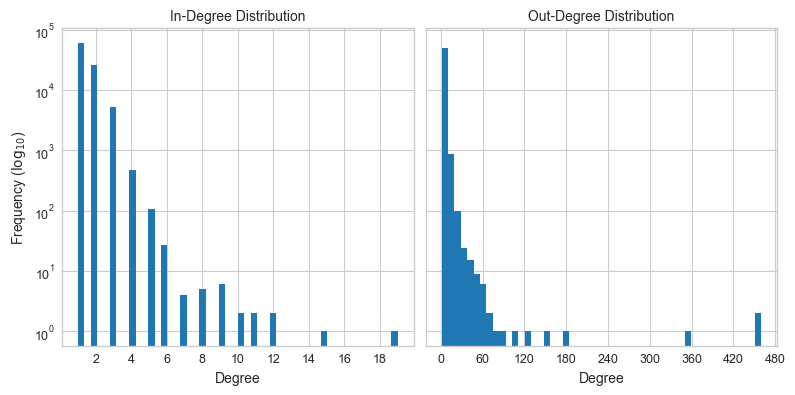

In [66]:
# Plot degree distribution
def plot_degree_distribution(edge_df, ax1, ax2, bins=50, log=True, **kwargs):
    degrees = edge_df["dst"].value_counts()
    ax1.hist(degrees, log=log, bins=bins, **kwargs)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    degrees = edge_df["src"].value_counts()
    ax2.hist(degrees, log=log, bins=bins, **kwargs)
    # ax2.set_ylabel("Frequency ($\log_{10}$)")
    ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


    return ax2, ax1

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

ax1, ax2 = axes

plot_degree_distribution(edges_post_df, ax1, ax2)

ax1.set_title("In-Degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency ($\log_{10}$)")

ax2.set_title("Out-Degree Distribution")
ax2.set_xlabel("Degree")

fig.tight_layout()

fig.savefig("figures/degree-distribution-pre.png", dpi=300)

### Component Sizes

In [67]:
# Get component sizes
component_sizes_pre = edges_pre_df.groupby("component").agg({"src": "count"})
# Select 99% of components
component_sizes_pre = component_sizes_pre.sort_values("src", ascending=True).query(
    "src > 9"
)
component_sizes_pre = component_sizes_pre.iloc[: int(len(component_sizes_pre) * 0.99)]

In [68]:
# graph_post = nx.from_pandas_edgelist(edges_post_df, "src", "dst")

In [69]:
# Get component sizes
component_sizes_post = edges_post_df.groupby("component").agg(
    {"is_anomalous": "sum", "src": "count"}
)
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("src", ascending=True)
component_sizes_post = component_sizes_post.iloc[
    : int(len(component_sizes_post) * 0.99)
]

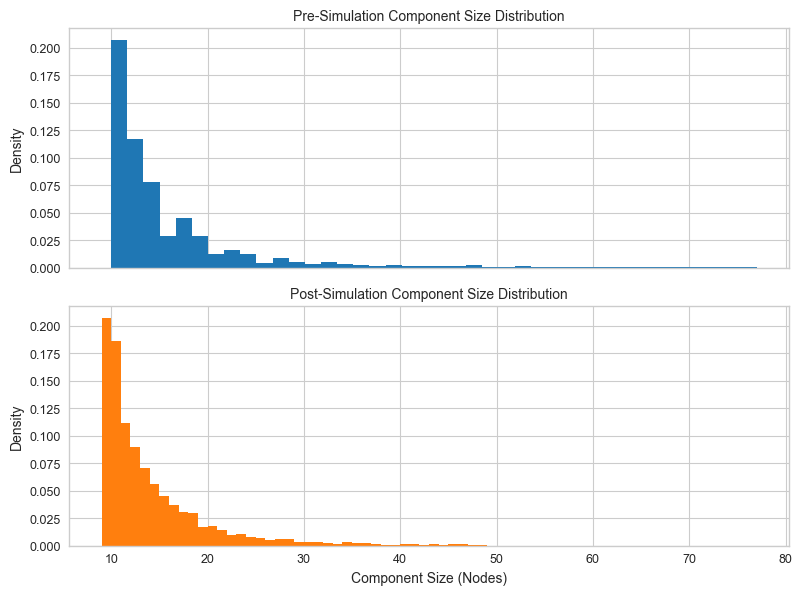

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
# fig2, ax2 = plt.subplots(figsize=(8, 4))

kwargs = dict(bins=40, density=True, logy=False)

component_sizes_pre["src"].plot.hist(**kwargs, ax=ax1)
ax1.set_title("Pre-Simulation Component Size Distribution")
ax1.set_xlabel("Component Size (Nodes)")
ax1.set_ylabel("Density")
# ax1.set_xlim(7, 80)
# ax1.set_ylim(0, 0.2)

component_sizes_post["src"].plot.hist(**kwargs, color="C1", ax=ax2)
ax2.set_title("Post-Simulation Component Size Distribution")
ax2.set_xlabel("Component Size (Nodes)")
ax2.set_ylabel("Density")
# ax2.set_xlim(7, 80)
# ax2.set_ylim(0, 0.2)

fig.tight_layout()

fig.savefig("figures/component-sizes.png", dpi=300)

In [71]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

### Anomaly Distribution

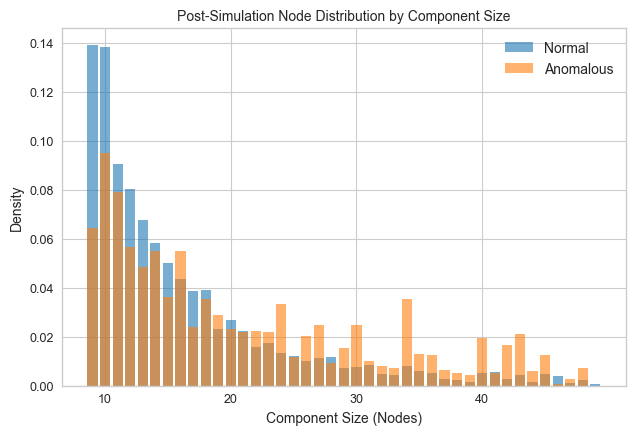

In [72]:
# Get component sizes
anomaly_dist_df = edges_post_df.groupby(["component", "is_anomalous"]).size()
anomaly_dist_df = anomaly_dist_df.unstack().fillna(0)
anomaly_dist_df["Total"] = anomaly_dist_df.sum(axis=1).astype(int)
anomaly_dist_df = anomaly_dist_df.sort_values("Total", ascending=True)
anomaly_dist_df = anomaly_dist_df.reset_index().rename(
    columns={False: "Normal", True: "Anomalous"}
)
# Select 99% of components
plot_data = anomaly_dist_df.sort_values("Total").iloc[
    : int(len(anomaly_dist_df) * 0.99)
]
plot_data = plot_data.groupby("Total")[["Normal", "Anomalous"]].sum()
# plot_data = plot_data.query("Total < 2000")
# Normalize plot_data columns
plot_data = plot_data / plot_data.sum()
ax = plt.gca()
ax.set_xticks(np.arange(0, plot_data.index.max(), 10))
ax.bar(plot_data.index, plot_data["Normal"], label="Normal", alpha=0.6)
ax.bar(plot_data.index, plot_data["Anomalous"], label="Anomalous", alpha=0.6)

ax.set_title("Post-Simulation Node Distribution by Component Size")
ax.set_xlabel("Component Size (Nodes)")
ax.set_ylabel("Density")
ax.legend()

fig = plt.gcf()
fig.tight_layout()

fig.savefig("figures/anomaly-distribution-component-size.png", dpi=300)


In [73]:
edges_post_df

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
0,0,2356236782051912119,3732317247976753020,True,75.0,False
1,0,2356236782051912119,14047622054401208865,True,75.0,False
2,0,692314493058510508,390416379365304942,True,25.0,False
3,0,15829769449001705952,3732317247976753020,True,75.0,False
4,0,15829769449001705952,17654996330473534901,True,75.0,False
...,...,...,...,...,...,...
131896,6863,18192837036067908255,15233613116661558738,True,25.0,False
131897,6863,18168561485814806981,7879326061664287605,True,25.0,False
131898,6863,2056455430524085329,7879326061664287605,True,25.0,False
131899,6863,15391449340824074448,15233613116661558738,True,25.0,False


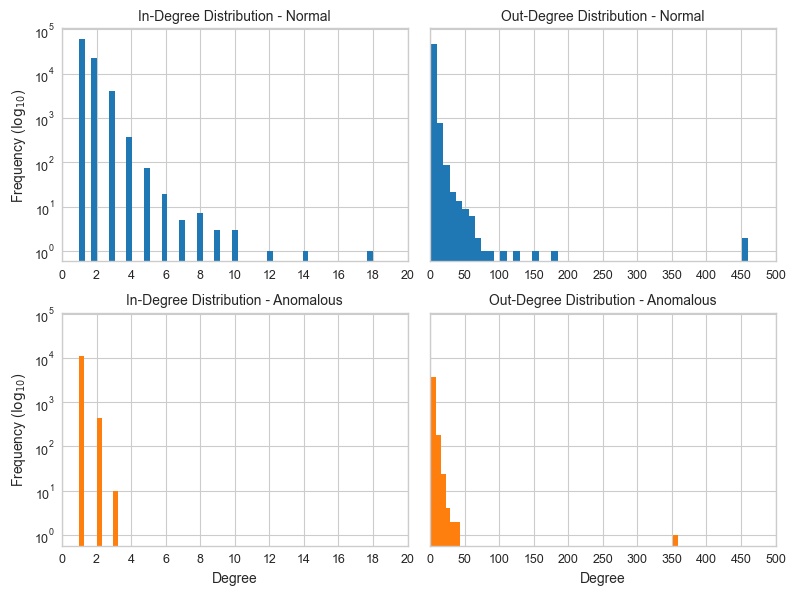

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=True)

(ax1, ax2, ax3, ax4) = np.ravel(axes)

plot_data = edges_post_df

plot_degree_distribution(plot_data.query("not is_anomalous"), ax1, ax2, bins=50)
plot_degree_distribution(plot_data.query("is_anomalous"), ax3, ax4, bins=50, color="C1")

ax1.set_title("In-Degree Distribution - Normal")
ax2.set_title("Out-Degree Distribution - Normal")

ax1.set_ylabel("Frequency ($\log_{10}$)")
ax3.set_ylabel("Frequency ($\log_{10}$)")

ax3.set_title("In-Degree Distribution - Anomalous")
ax4.set_title("Out-Degree Distribution - Anomalous")

# Set ax3 to use same xticks as ax1
ax1.set_xlim(0, 20)
ax3.set_xlim(0, 20)

ax2.set_xlim(0, 500)
ax4.set_xlim(0, 500)

ax3.set_xlabel("Degree")
ax4.set_xlabel("Degree")

# Set bar width on ax3
for series in ax3.patches:
    series.set_width(0.3)

fig.tight_layout()

fig.savefig("figures/degree-distributions-post.png", dpi=300)


In [75]:
plot_data

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
0,0,2356236782051912119,3732317247976753020,True,75.0,False
1,0,2356236782051912119,14047622054401208865,True,75.0,False
2,0,692314493058510508,390416379365304942,True,25.0,False
3,0,15829769449001705952,3732317247976753020,True,75.0,False
4,0,15829769449001705952,17654996330473534901,True,75.0,False
...,...,...,...,...,...,...
131896,6863,18192837036067908255,15233613116661558738,True,25.0,False
131897,6863,18168561485814806981,7879326061664287605,True,25.0,False
131898,6863,2056455430524085329,7879326061664287605,True,25.0,False
131899,6863,15391449340824074448,15233613116661558738,True,25.0,False


## Simulation

In [76]:
graph_edges_post = edges_post_df.query("component == 23")
graph_edges_pre = edges_pre_df.query("component == 77309426934").sort_values("src")
edges_in_pre_not_in_post = graph_edges_pre.query(
    "src not in @graph_edges_post.src.values"
)

In [77]:
graph_pre = nx.DiGraph()
graph_pre.add_nodes_from(graph_edges_pre["src"].unique())
graph_pre.add_nodes_from(graph_edges_pre["dst"].unique())
graph_pre.add_edges_from(graph_edges_pre[["src", "dst"]].values)

In [78]:
graph_post = nx.DiGraph()
graph_post.add_nodes_from(graph_edges_post["src"].unique())
graph_post.add_nodes_from(graph_edges_post["dst"].unique())
graph_post.add_edges_from(graph_edges_post[["src", "dst"]].values)

In [79]:
node_c = "lightblue"
new_node_c = "lightgreen"
dropped_node_c = "lightpink"
anomalous_node_c = "darkorange"

edge_c = "lightgrey"
new_edge_c = "green"
dropped_edge_c = "red"

In [80]:
i = 168
print(i)
pos = nx.drawing.spring_layout(graph_pre, seed=i, iterations=100, k=0.8)

NODE_SIZE = 50
anomaly_id = "2258222399048453312"
pos[anomaly_id] = [-0.40, 0.21]


def plot_pre(ax):

    edge_colours = [edge_c for u, v in graph_pre.edges]
    node_colours = [node_c for n in graph_pre.nodes]

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )


168


In [81]:
def plot_mid(ax):
    # Colour edges that are in the pre graph but not in the post graph
    edge_colours = [
        dropped_edge_c if (u) == "2258222399048453312" else edge_c
        for u, v in graph_pre.edges
    ]
    node_colours = [
        node_c if n in graph_post.nodes else dropped_node_c for n in graph_pre.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_pre.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

In [82]:
def plot_post(ax):
    pos2 = {**pos, "11395388473527546194": pos["17957350210417364187"]}

    # Colour edges in the post graph that are not in the pre graph
    edge_colours = [
        new_edge_c if u == "2258222399048453312" else edge_c
        for u, v in graph_post.edges
    ]
    node_colours = [
        node_c if n in graph_pre.nodes else new_node_c for n in graph_post.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_post.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_post,
        pos=pos2,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_post.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

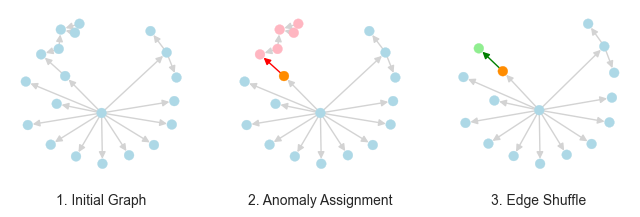

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.2))
# fig, axes = plt.subplots(3, 1, figsize=(3, 8))
axes[0].set_title("1. Initial Graph", y=-0.2)
axes[1].set_title("2. Anomaly Assignment", y=-0.2)
axes[2].set_title("3. Edge Shuffle", y=-0.2)

plot_pre(axes[0])
plot_mid(axes[1])
plot_post(axes[2])

fig.savefig("figures/anomaly-simulation-process.png", dpi=300, bbox_inches="tight")